## Colorization

In [1]:
import torch
import torch.nn as nn

device = torch.device('cuda:0')  # используй первую GPU (номеруются с нуля)

tensor([[-0.0179,  0.0931,  0.0127, -0.2338, -0.2009, -0.3245, -0.2304, -0.1470],
        [ 0.1603,  0.4848,  0.1112, -0.2529, -0.3787, -0.2782,  0.1682, -0.1547],
        [-0.2261,  0.0726,  0.1356,  0.0133,  0.4808,  0.0528, -0.1443, -0.0139],
        [-0.0941, -0.0938,  0.2644, -0.0818, -0.4007,  0.2548, -0.0316, -0.1476],
        [ 0.0702,  0.0075, -0.0150, -0.4790, -0.0189,  0.2140, -0.1774,  0.2351]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [2]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [3]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2021-10-29 07:55:50--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  6.40MB/s    in 17s     

2021-10-29 07:56:08 (3.97 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



In [4]:
from tqdm.notebook import tqdm
from time import sleep


  0%|          | 0/10 [00:00<?, ?it/s]

### Preprocessing

In [5]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Чтобы подавать картинки на вход нейросети, нужно их перевести в тензоры, причём одинакового размера.

In [6]:
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    transforms.ColorJitter(),
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

In [7]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

  0%|          | 0/1254 [00:00<?, ?it/s]

### Create and train model

In [18]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),                                 
            nn.MaxPool2d((2, 2), stride=(2, 2)), 
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, (3, 3), padding=1),                                
            nn.MaxPool2d((2, 2), stride=(2, 2)), 
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(),
            nn.Conv2d(64, 256, (3, 3), padding=1),                               
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(),
            
            nn.Upsample(scale_factor=2),        
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(128),
            nn.Dropout(),
            nn.Conv2d(128, 64, (3, 3), padding=1), 
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(64),
            nn.Dropout(),
            nn.Conv2d(64, 64, (3, 3), padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
        )
         
        self.postconcat = nn.Sequential(         
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [ ]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

In [9]:
def show_image(epoch):
    img_gray, img_true = dataset[epoch]
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

In [21]:
num_epochs = 100
lr = 1e-4

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.L1Loss() 

In [ ]:
history = []
for epoch in tqdm(range(num_epochs)):
    ep_loss = 0
    model.train()
    for x, y in loader:
        
        x = x.to(device)
        y = y.to(device) 

        optimizer.zero_grad()
        output = model(x)
      
        loss = criterion(output, y)
        ep_loss += loss.item()
      
        history.append(loss.item())
      
        loss.backward()
       
        optimizer.step()
        del x
        del y 
        torch.cuda.empty_cache()

    scheduler.step()
    print(f'{epoch} epoch: {ep_loss/64}')
    model.eval()
    show_image(epoch)


In [26]:
torch.save(model, 'colorization_model_model')

In [27]:
model = torch.load('colorization_model_model')
model.eval()

Colorizer(
  (preconcat): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.5, 

В подобных нечётко поставленных задачах важно смотреть не цифры, а на реальные примеры.


### Посмотрим на результат

1.На фото природы (где много зелени) сетка справляется неплохо, хотя конечно присутствует любовь к раскрашиванию все зеленым 

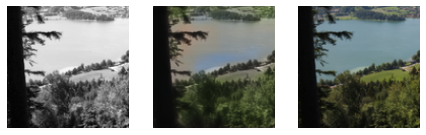

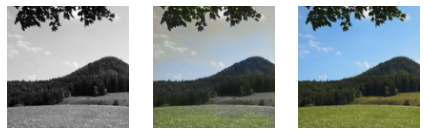

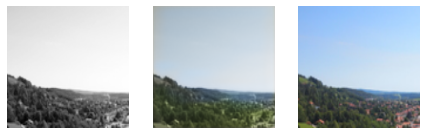

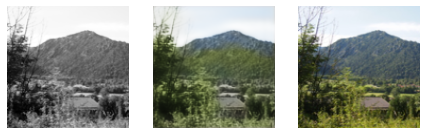

In [36]:
for i in [76, 66, 53, 51]:
    show_image(i)

2. С людьми работать тяжелее, она опять хочет покрасить волосы в болотный, но зато сеть старается раскрашивать лица в телесный цвет

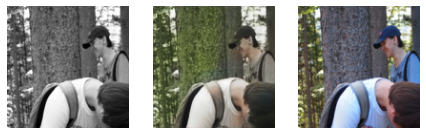

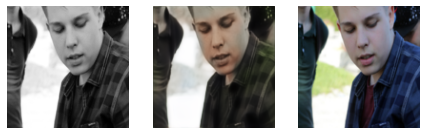

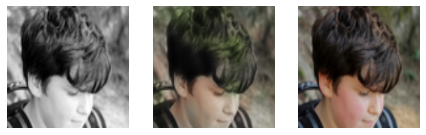

In [37]:
for i in [80, 90, 94]:
    show_image(i)